# Generative Adversarial Networks (GANs): A Simple Example with MNIST
## Vignette PSTAT 197A Fall 2025
### Contributers: Sam Caruthers, Aidan Frazier, Anna Gornyitzki, Charles Yang, Justin Zhou



This notebook introduces **Generative Adversarial Networks (GANs)** using the MNIST handwritten digits dataset.

We will:
- Explain the basic idea of GANs in simple terms.
- Load the MNIST dataset of handwritten digits (0–9).
- Build a very small **Generator** and **Discriminator** using PyTorch.
- Train the GAN to create fake digit images.
- Visualize the generated digits as training progresses.

This notebook is meant for undergraduate students who have some basic experience with Python and Jupyter, but no prior experience with GANs.


In [1]:
# If running on a fresh environment, you may need to install PyTorch and torchvision.
# You can uncomment and run the line below if PyTorch is not installed.
!pip3 install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


### Checking for GPU Availability

Check whether your computer has a **GPU (Graphics Processing Unit)** available for training.

- **GPU (CUDA)**: If you have an NVIDIA GPU with CUDA installed, PyTorch will use it. Training will be **much faster** (5-10 minutes for 100 epochs).
- **CPU**: If no GPU is available, PyTorch will use your regular processor. Training will be **slower** (30-60 minutes for 100 epochs) but will still work.

On a Mac, the output will typically be `device(type='cpu')` since Macs don't have CUDA-compatible GPUs. However, newer Macs with Apple Silicon (M1/M2/M3) can use Metal Performance Shaders (MPS) for acceleration, though we're using the simpler CPU/CUDA setup here for compatibility.

Throughout this notebook, we'll use `.to(device)` to move our neural networks and data to whichever device is available, ensuring everything runs on the same hardware.

In [2]:
# Use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## What is a GAN?

A **Generative Adversarial Network (GAN)** is made of two neural networks that *compete* with each other:

- **Generator (G)**: takes random noise as input and tries to create **fake images** that look real.
- **Discriminator (D)**: takes an image as input and tries to decide whether it is **real (from the dataset)** or **fake (from the generator)**.

You can think of it like:

- The **Generator** is a *forger* trying to create fake art.
- The **Discriminator** is a *detective* trying to spot fake art.
- Over time, both get better: the generator makes more realistic images, and the discriminator becomes a better critic.

In this notebook, we train a simple GAN to generate **28×28 pixel images of digits** using the MNIST dataset.


### Loading and Visualizing the MNIST Dataset

Before we build our GAN, let's load the data and see what we're working with.

First, we load the MNIST dataset of handwritten digits and apply transformations to convert images to tensors and normalize pixel values from [0,1] to [-1,1]. We create a DataLoader that feeds batches of 64 images to our training loop.

Next, we visualize a sample of 8 real handwritten digits from the dataset. This gives us a baseline to compare against - our goal is for the Generator to eventually create fake digits that look just as realistic as these real ones!

The MNIST dataset contains 60,000 training images of handwritten digits (0-9), each 28×28 pixels in grayscale. We normalize the pixel values to [-1, 1] because our Generator will use a `Tanh` activation function that outputs values in this range.

In [3]:
# Transform: convert image to tensor and scale to [-1, 1] (helpful for Tanh output later)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # from [0,1] to [-1,1]
])

# Download and load training data
mnist_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)

batch_size = 64
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

len(mnist_dataset), batch_size

(60000, 64)

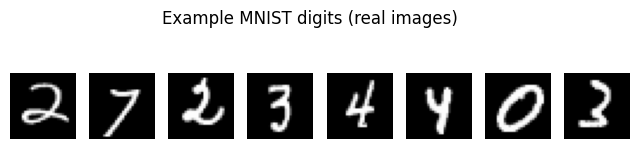

In [5]:
# Get one batch of images
real_batch = next(iter(dataloader))
images, labels = real_batch

# Plot first 8 images in the batch
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    img = images[i].squeeze().numpy()  # remove channels dimension
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Example MNIST digits (real images)")
plt.show()

### Setting Up Hyperparameters

Now we define the key settings for our GAN:

- **`z_dim = 64`**: The size of the random noise vector that the Generator will use as input. Think of this as the "seed" from which fake images will be created.
- **`img_size = 28 * 28 = 784`**: The flattened size of our output images (28×28 pixels).
- **`num_epochs = 50`**: We'll train for 50 epochs (one epoch = one pass through the entire dataset). This should be enough to see clear improvement in image quality.
- **`lr = 2e-4`**: The learning rate controls how big the steps are when updating the networks. This value (0.0002) is commonly used for GANs.
- **`print_every = 200`**: Print training progress every 200 batches.
- **`save_interval = 5`**: Generate and display sample images every 5 epochs so we can watch the GAN improve over time.

In [6]:
# Size of the noise vector (input to the generator)
z_dim = 64

# Size of flattened image (28 x 28)
img_size = 28 * 28

# Training settings
num_epochs = 50         # increased from 5 to 50 for better quality results
lr = 2e-4               # learning rate
print_every = 200       # how often to print training progress
save_interval = 5       # save and display images every N epochs

z_dim, img_size

(64, 784)

## Building the Generator and Discriminator Networks

Now we define the two neural networks that will compete with each other.

### The Generator
The **Generator** is a neural network that transforms random noise into fake images:
- **Input**: A random noise vector of size 64
- **Hidden layers**: Two fully connected layers (256 and 512 neurons) with ReLU activation and Batch Normalization for stable training
- **Output**: 784 values (28×28 pixels) passed through Tanh activation to produce values in [-1, 1]
- The output is reshaped into a 28×28 image

### The Discriminator
The **Discriminator** is a neural network that acts as a detective, trying to distinguish real images from fake ones:
- **Input**: A flattened 28×28 image (784 values)
- **Hidden layers**: Two fully connected layers (512 and 256 neurons) with LeakyReLU activation and Dropout (0.3) to prevent overfitting
- **Output**: A single probability value between 0 and 1, where 1 means "real" and 0 means "fake"

Both networks are moved to our device (CPU or GPU) for training.

In [7]:
class Generator(nn.Module):
    """
    The Generator takes random noise (z) as input and outputs a fake image.
    We use a fully connected network (MLP) with batch normalization for better training.
    """
    def __init__(self, z_dim, img_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),  # Added batch normalization
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )
        
    def forward(self, z):
        x = self.model(z)
        # reshape to (batch_size, 1, 28, 28)
        return x.view(-1, 1, 28, 28)

generator = Generator(z_dim, img_size).to(device)
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    """
    The Discriminator takes an image and outputs a single number between 0 and 1:
    - 1 means 'real'
    - 0 means 'fake'
    We use dropout for regularization to prevent overfitting.
    """
    def __init__(self, img_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Added dropout for regularization
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # output probability
        )
        
    def forward(self, x):
        # flatten image to vector
        x = x.view(x.size(0), -1)
        return self.model(x)

discriminator = Discriminator(img_size).to(device)
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

## Setting Up the Loss Function and Optimizers

Before we can train our GAN, we need to define how we'll measure performance and update the networks:

**Loss Function**: We use **Binary Cross-Entropy (BCE) Loss**, which is perfect for binary classification tasks (real vs. fake). This loss measures how well the Discriminator classifies images and how well the Generator fools the Discriminator.

**Optimizers**: We use the **Adam optimizer** for both networks with a learning rate of 0.0002. Adam is popular for training GANs because it adapts the learning rate for each parameter and helps with stable convergence. Each network gets its own optimizer so they can be updated independently during the adversarial training process.

In [9]:
# Binary Cross Entropy loss: good for classifying real vs fake
criterion = nn.BCELoss()

# Adam optimizers for both networks
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


## Training the GAN

Now we're ready to train our GAN! This training process will run for **100 epochs** and show you how the Generator improves over time. An epoch is one complete pass through the entire training dataset. 

**What happens during training:**
- The two networks compete in an adversarial game for 100 epochs
- The Discriminator learns to distinguish real MNIST digits from fake ones
- The Generator learns to create increasingly realistic fake digits to fool the Discriminator
- We'll display generated images at specific checkpoints: **Epochs 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, and 100**
- Images from **Epochs 1, 50, and 100** will be saved for a final comparison

**What to expect:**
- **Epoch 1**: The Generator produces random noise - barely recognizable as digits
- **Epochs 10-50**: Digit-like shapes emerge, getting clearer over time
- **Epochs 50-100**: Realistic handwritten digits that could pass for real MNIST samples

**Training progress:** Every 200 batches, you'll see the loss values for both networks. These losses show how well each network is performing:
- **Loss D** (Discriminator): How well it classifies real vs. fake images
- **Loss G** (Generator): How well it fools the Discriminator

At the end, we'll display a side-by-side comparison of the Generator's output at the beginning, middle, and end of training so you can see the dramatic improvement!

*Note: Training 100 epochs will take approximately 30-60 minutes on CPU, or 5-10 minutes on GPU.*

In [26]:
# Reinitialize the networks to start fresh
# This is important if you've already trained them before
generator = Generator(z_dim, img_size).to(device)
discriminator = Discriminator(img_size).to(device)

# Recreate the optimizers with the fresh network parameters
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Reset the loss tracking lists
G_losses = []
D_losses = []

print("Networks reinitialized and ready for fresh training!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")

Networks reinitialized and ready for fresh training!
Generator parameters: 551952
Discriminator parameters: 533505


Starting GAN Training for 100 epochs
Images will be displayed at epochs: [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
All displayed images will be saved for later export

Epoch [1/100] Batch [0/938] Loss D: 1.4100, Loss G: 0.6975
Epoch [1/100] Batch [200/938] Loss D: 0.0777, Loss G: 12.7882
Epoch [1/100] Batch [400/938] Loss D: 0.1152, Loss G: 6.1099
Epoch [1/100] Batch [600/938] Loss D: 0.0346, Loss G: 7.0635
Epoch [1/100] Batch [800/938] Loss D: 0.0282, Loss G: 6.4897

Displaying Generated Samples at Epoch 1


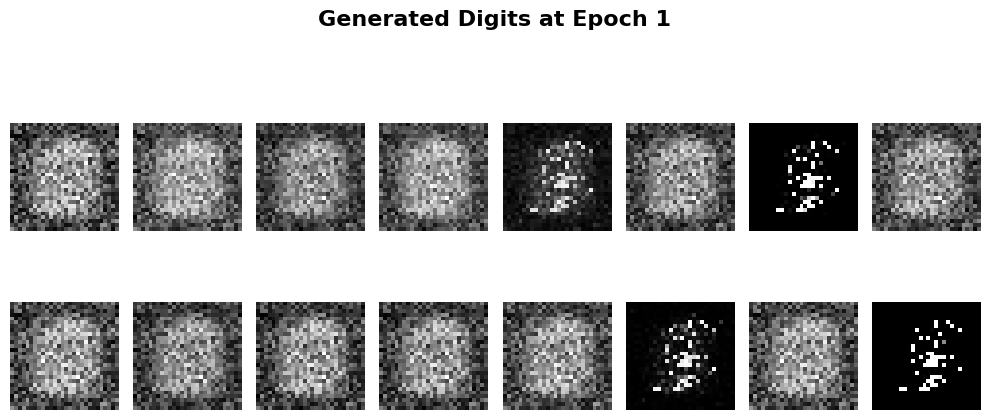


Epoch [2/100] Batch [0/938] Loss D: 0.1017, Loss G: 7.6385
Epoch [2/100] Batch [200/938] Loss D: 0.1099, Loss G: 4.7203
Epoch [2/100] Batch [400/938] Loss D: 0.1977, Loss G: 8.8459
Epoch [2/100] Batch [600/938] Loss D: 0.0800, Loss G: 6.0172
Epoch [2/100] Batch [800/938] Loss D: 0.2347, Loss G: 6.4898
Epoch [3/100] Batch [0/938] Loss D: 0.0716, Loss G: 6.2727
Epoch [3/100] Batch [200/938] Loss D: 0.0440, Loss G: 4.6427
Epoch [3/100] Batch [400/938] Loss D: 0.0913, Loss G: 4.6690
Epoch [3/100] Batch [600/938] Loss D: 0.1481, Loss G: 4.4586
Epoch [3/100] Batch [800/938] Loss D: 0.1768, Loss G: 5.7831
Epoch [4/100] Batch [0/938] Loss D: 0.2939, Loss G: 5.5318
Epoch [4/100] Batch [200/938] Loss D: 0.2546, Loss G: 5.4109
Epoch [4/100] Batch [400/938] Loss D: 0.3933, Loss G: 4.5310
Epoch [4/100] Batch [600/938] Loss D: 0.2414, Loss G: 3.9666
Epoch [4/100] Batch [800/938] Loss D: 0.3499, Loss G: 4.3269
Epoch [5/100] Batch [0/938] Loss D: 0.1270, Loss G: 6.7723
Epoch [5/100] Batch [200/938] L

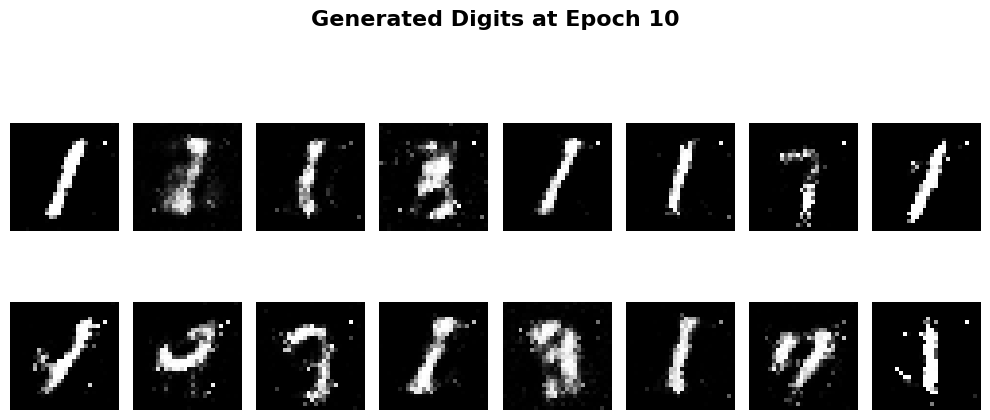


Epoch [11/100] Batch [0/938] Loss D: 0.8433, Loss G: 1.5578
Epoch [11/100] Batch [200/938] Loss D: 0.4900, Loss G: 1.6350
Epoch [11/100] Batch [400/938] Loss D: 0.4425, Loss G: 3.1505
Epoch [11/100] Batch [600/938] Loss D: 0.6301, Loss G: 2.4712
Epoch [11/100] Batch [800/938] Loss D: 0.4117, Loss G: 2.5879
Epoch [12/100] Batch [0/938] Loss D: 0.5727, Loss G: 2.2154
Epoch [12/100] Batch [200/938] Loss D: 0.5350, Loss G: 2.4553
Epoch [12/100] Batch [400/938] Loss D: 0.6029, Loss G: 3.7440
Epoch [12/100] Batch [600/938] Loss D: 0.5407, Loss G: 2.6798
Epoch [12/100] Batch [800/938] Loss D: 0.4626, Loss G: 3.4077
Epoch [13/100] Batch [0/938] Loss D: 0.2314, Loss G: 5.3820
Epoch [13/100] Batch [200/938] Loss D: 0.1091, Loss G: 6.7416
Epoch [13/100] Batch [400/938] Loss D: 0.0783, Loss G: 10.7485
Epoch [13/100] Batch [600/938] Loss D: 0.1544, Loss G: 4.7390
Epoch [13/100] Batch [800/938] Loss D: 0.3750, Loss G: 2.5159
Epoch [14/100] Batch [0/938] Loss D: 0.4961, Loss G: 3.1127
Epoch [14/100]

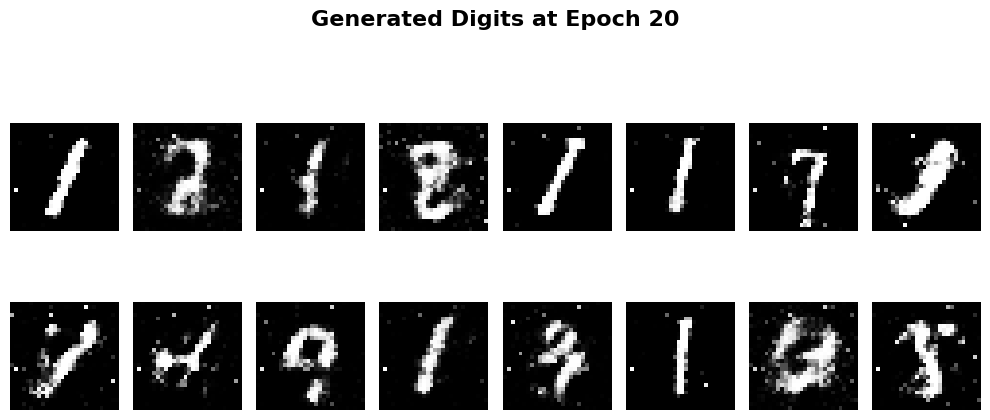


Epoch [21/100] Batch [0/938] Loss D: 0.5081, Loss G: 3.2563
Epoch [21/100] Batch [200/938] Loss D: 0.5025, Loss G: 3.0557
Epoch [21/100] Batch [400/938] Loss D: 0.7551, Loss G: 1.7000
Epoch [21/100] Batch [600/938] Loss D: 0.7455, Loss G: 1.3727
Epoch [21/100] Batch [800/938] Loss D: 1.0779, Loss G: 1.2695
Epoch [22/100] Batch [0/938] Loss D: 0.9024, Loss G: 1.9174
Epoch [22/100] Batch [200/938] Loss D: 0.6777, Loss G: 1.8172
Epoch [22/100] Batch [400/938] Loss D: 0.5166, Loss G: 2.1619
Epoch [22/100] Batch [600/938] Loss D: 0.6758, Loss G: 1.4783
Epoch [22/100] Batch [800/938] Loss D: 0.8011, Loss G: 1.7714
Epoch [23/100] Batch [0/938] Loss D: 0.7813, Loss G: 2.9728
Epoch [23/100] Batch [200/938] Loss D: 0.6891, Loss G: 2.2330
Epoch [23/100] Batch [400/938] Loss D: 0.9052, Loss G: 1.5722
Epoch [23/100] Batch [600/938] Loss D: 0.8001, Loss G: 1.6917
Epoch [23/100] Batch [800/938] Loss D: 0.7934, Loss G: 2.1483
Epoch [24/100] Batch [0/938] Loss D: 0.7797, Loss G: 2.3860
Epoch [24/100] 

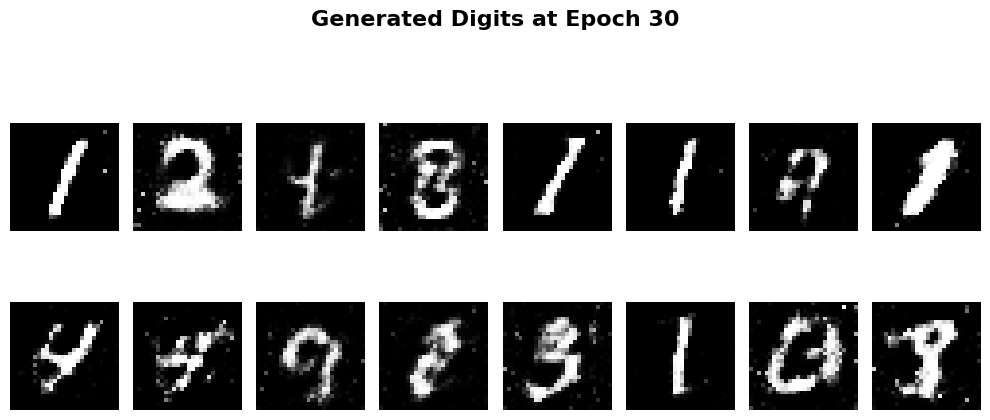


Epoch [31/100] Batch [0/938] Loss D: 0.9192, Loss G: 1.5100
Epoch [31/100] Batch [200/938] Loss D: 1.2836, Loss G: 1.0222
Epoch [31/100] Batch [400/938] Loss D: 1.0115, Loss G: 1.7071
Epoch [31/100] Batch [600/938] Loss D: 0.9731, Loss G: 1.5869
Epoch [31/100] Batch [800/938] Loss D: 0.7595, Loss G: 1.3632
Epoch [32/100] Batch [0/938] Loss D: 0.8857, Loss G: 2.0258
Epoch [32/100] Batch [200/938] Loss D: 0.6862, Loss G: 2.3016
Epoch [32/100] Batch [400/938] Loss D: 1.0221, Loss G: 1.7282
Epoch [32/100] Batch [600/938] Loss D: 0.8293, Loss G: 1.6357
Epoch [32/100] Batch [800/938] Loss D: 1.0775, Loss G: 1.2031
Epoch [33/100] Batch [0/938] Loss D: 1.0020, Loss G: 1.7906
Epoch [33/100] Batch [200/938] Loss D: 0.9893, Loss G: 1.1827
Epoch [33/100] Batch [400/938] Loss D: 0.8397, Loss G: 2.0514
Epoch [33/100] Batch [600/938] Loss D: 0.9569, Loss G: 1.7192
Epoch [33/100] Batch [800/938] Loss D: 1.0628, Loss G: 1.5563
Epoch [34/100] Batch [0/938] Loss D: 0.8332, Loss G: 1.8861
Epoch [34/100] 

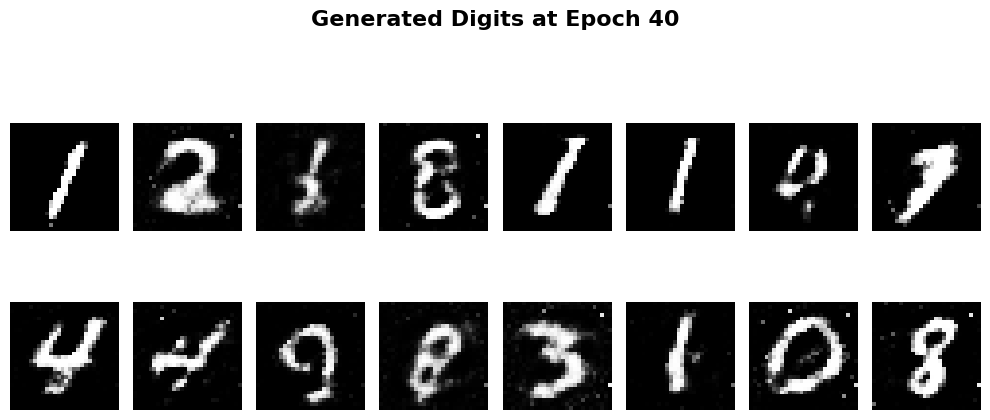


Epoch [41/100] Batch [0/938] Loss D: 1.0300, Loss G: 1.3868
Epoch [41/100] Batch [200/938] Loss D: 1.0394, Loss G: 1.4604
Epoch [41/100] Batch [400/938] Loss D: 1.0196, Loss G: 1.5758
Epoch [41/100] Batch [600/938] Loss D: 1.1418, Loss G: 1.4529
Epoch [41/100] Batch [800/938] Loss D: 1.4215, Loss G: 1.2930
Epoch [42/100] Batch [0/938] Loss D: 1.2257, Loss G: 1.4040
Epoch [42/100] Batch [200/938] Loss D: 1.1216, Loss G: 1.4331
Epoch [42/100] Batch [400/938] Loss D: 1.2426, Loss G: 1.5239
Epoch [42/100] Batch [600/938] Loss D: 1.2595, Loss G: 1.2342
Epoch [42/100] Batch [800/938] Loss D: 1.1120, Loss G: 1.1285
Epoch [43/100] Batch [0/938] Loss D: 1.2632, Loss G: 1.1093
Epoch [43/100] Batch [200/938] Loss D: 1.1291, Loss G: 1.2330
Epoch [43/100] Batch [400/938] Loss D: 0.9449, Loss G: 1.2961
Epoch [43/100] Batch [600/938] Loss D: 1.1420, Loss G: 1.0734
Epoch [43/100] Batch [800/938] Loss D: 0.9140, Loss G: 1.3844
Epoch [44/100] Batch [0/938] Loss D: 1.0640, Loss G: 1.3267
Epoch [44/100] 

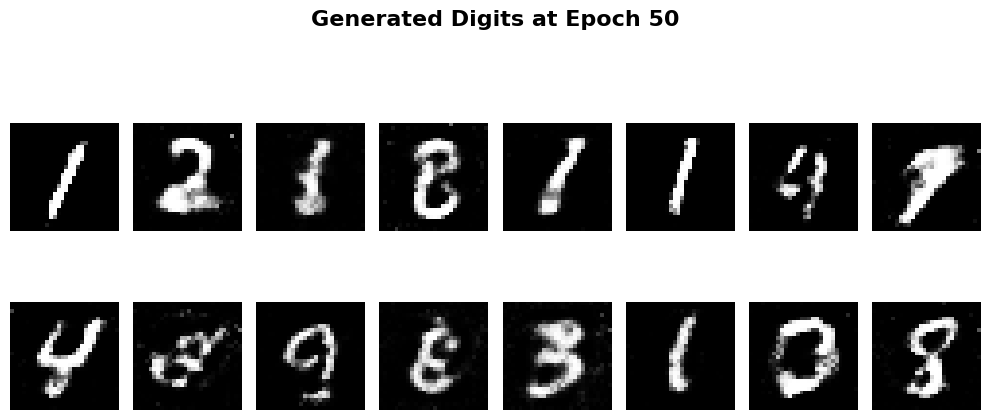


Epoch [51/100] Batch [0/938] Loss D: 1.2247, Loss G: 1.1030
Epoch [51/100] Batch [200/938] Loss D: 1.3433, Loss G: 1.0169
Epoch [51/100] Batch [400/938] Loss D: 1.1816, Loss G: 1.1032
Epoch [51/100] Batch [600/938] Loss D: 1.0536, Loss G: 1.2138
Epoch [51/100] Batch [800/938] Loss D: 0.9927, Loss G: 1.1528
Epoch [52/100] Batch [0/938] Loss D: 1.0096, Loss G: 1.6070
Epoch [52/100] Batch [200/938] Loss D: 1.0090, Loss G: 1.1519
Epoch [52/100] Batch [400/938] Loss D: 1.1890, Loss G: 1.0440
Epoch [52/100] Batch [600/938] Loss D: 0.8336, Loss G: 1.3984
Epoch [52/100] Batch [800/938] Loss D: 1.1555, Loss G: 1.0002
Epoch [53/100] Batch [0/938] Loss D: 1.1601, Loss G: 1.1989
Epoch [53/100] Batch [200/938] Loss D: 0.9900, Loss G: 1.2212
Epoch [53/100] Batch [400/938] Loss D: 1.1298, Loss G: 1.0192
Epoch [53/100] Batch [600/938] Loss D: 1.2071, Loss G: 1.3574
Epoch [53/100] Batch [800/938] Loss D: 0.9187, Loss G: 1.5568
Epoch [54/100] Batch [0/938] Loss D: 1.1906, Loss G: 1.4869
Epoch [54/100] 

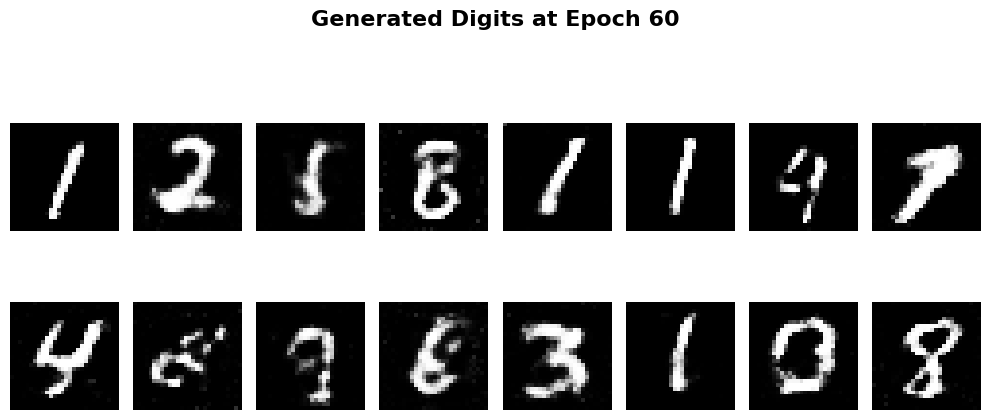


Epoch [61/100] Batch [0/938] Loss D: 1.2180, Loss G: 0.8741
Epoch [61/100] Batch [200/938] Loss D: 0.9956, Loss G: 1.1589
Epoch [61/100] Batch [400/938] Loss D: 1.0019, Loss G: 1.0540
Epoch [61/100] Batch [600/938] Loss D: 0.8285, Loss G: 2.0237
Epoch [61/100] Batch [800/938] Loss D: 1.2354, Loss G: 0.9712
Epoch [62/100] Batch [0/938] Loss D: 1.0158, Loss G: 1.5328
Epoch [62/100] Batch [200/938] Loss D: 1.1810, Loss G: 0.9938
Epoch [62/100] Batch [400/938] Loss D: 0.9425, Loss G: 1.5357
Epoch [62/100] Batch [600/938] Loss D: 1.2728, Loss G: 1.0037
Epoch [62/100] Batch [800/938] Loss D: 1.1216, Loss G: 1.3412
Epoch [63/100] Batch [0/938] Loss D: 1.3187, Loss G: 0.9346
Epoch [63/100] Batch [200/938] Loss D: 1.0283, Loss G: 1.2554
Epoch [63/100] Batch [400/938] Loss D: 1.0195, Loss G: 1.3535
Epoch [63/100] Batch [600/938] Loss D: 1.3064, Loss G: 1.0910
Epoch [63/100] Batch [800/938] Loss D: 1.0049, Loss G: 1.3288
Epoch [64/100] Batch [0/938] Loss D: 1.3237, Loss G: 0.7730
Epoch [64/100] 

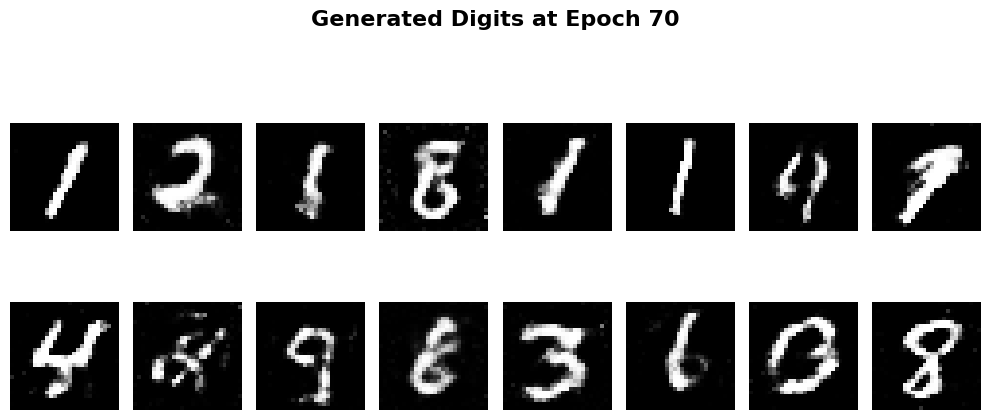


Epoch [71/100] Batch [0/938] Loss D: 1.1644, Loss G: 1.0823
Epoch [71/100] Batch [200/938] Loss D: 1.0414, Loss G: 1.1454
Epoch [71/100] Batch [400/938] Loss D: 1.2149, Loss G: 1.0076
Epoch [71/100] Batch [600/938] Loss D: 1.1690, Loss G: 0.9371
Epoch [71/100] Batch [800/938] Loss D: 1.0023, Loss G: 1.0076
Epoch [72/100] Batch [0/938] Loss D: 1.3717, Loss G: 0.9902
Epoch [72/100] Batch [200/938] Loss D: 1.2123, Loss G: 1.3000
Epoch [72/100] Batch [400/938] Loss D: 1.0117, Loss G: 1.0650
Epoch [72/100] Batch [600/938] Loss D: 1.1396, Loss G: 1.5716
Epoch [72/100] Batch [800/938] Loss D: 1.3573, Loss G: 0.7950
Epoch [73/100] Batch [0/938] Loss D: 1.1717, Loss G: 1.1478
Epoch [73/100] Batch [200/938] Loss D: 1.3150, Loss G: 0.9521
Epoch [73/100] Batch [400/938] Loss D: 0.9592, Loss G: 1.1962
Epoch [73/100] Batch [600/938] Loss D: 1.3411, Loss G: 0.9016
Epoch [73/100] Batch [800/938] Loss D: 1.1310, Loss G: 1.1214
Epoch [74/100] Batch [0/938] Loss D: 1.1256, Loss G: 1.1301
Epoch [74/100] 

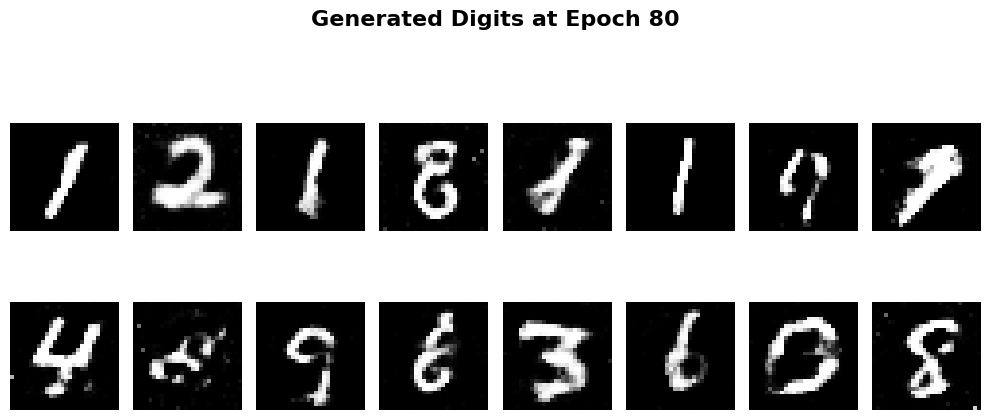


Epoch [81/100] Batch [0/938] Loss D: 1.1889, Loss G: 1.1102
Epoch [81/100] Batch [200/938] Loss D: 1.1872, Loss G: 1.0233
Epoch [81/100] Batch [400/938] Loss D: 1.1663, Loss G: 0.9085
Epoch [81/100] Batch [600/938] Loss D: 1.0742, Loss G: 1.1406
Epoch [81/100] Batch [800/938] Loss D: 1.3725, Loss G: 1.0623
Epoch [82/100] Batch [0/938] Loss D: 1.0338, Loss G: 1.1319
Epoch [82/100] Batch [200/938] Loss D: 1.4661, Loss G: 0.9955
Epoch [82/100] Batch [400/938] Loss D: 1.2786, Loss G: 0.8004
Epoch [82/100] Batch [600/938] Loss D: 1.0879, Loss G: 1.1732
Epoch [82/100] Batch [800/938] Loss D: 1.2831, Loss G: 1.1044
Epoch [83/100] Batch [0/938] Loss D: 1.0840, Loss G: 1.2785
Epoch [83/100] Batch [200/938] Loss D: 1.2602, Loss G: 1.0301
Epoch [83/100] Batch [400/938] Loss D: 1.2521, Loss G: 1.0132
Epoch [83/100] Batch [600/938] Loss D: 1.0032, Loss G: 1.1147
Epoch [83/100] Batch [800/938] Loss D: 1.2252, Loss G: 0.9919
Epoch [84/100] Batch [0/938] Loss D: 1.1837, Loss G: 0.8967
Epoch [84/100] 

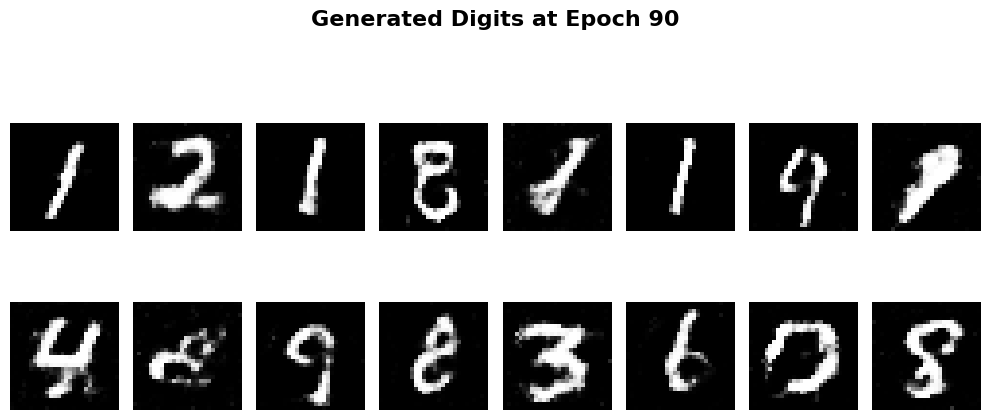


Epoch [91/100] Batch [0/938] Loss D: 1.1028, Loss G: 0.8897
Epoch [91/100] Batch [200/938] Loss D: 1.0838, Loss G: 1.2862
Epoch [91/100] Batch [400/938] Loss D: 1.0747, Loss G: 1.3531
Epoch [91/100] Batch [600/938] Loss D: 1.2971, Loss G: 1.3828
Epoch [91/100] Batch [800/938] Loss D: 1.3283, Loss G: 0.9267
Epoch [92/100] Batch [0/938] Loss D: 1.0334, Loss G: 1.3639
Epoch [92/100] Batch [200/938] Loss D: 1.3279, Loss G: 0.7665
Epoch [92/100] Batch [400/938] Loss D: 1.0009, Loss G: 1.2239
Epoch [92/100] Batch [600/938] Loss D: 1.3664, Loss G: 1.1340
Epoch [92/100] Batch [800/938] Loss D: 1.3151, Loss G: 0.8493
Epoch [93/100] Batch [0/938] Loss D: 1.1890, Loss G: 1.0418
Epoch [93/100] Batch [200/938] Loss D: 1.0511, Loss G: 1.4286
Epoch [93/100] Batch [400/938] Loss D: 1.4869, Loss G: 0.8425
Epoch [93/100] Batch [600/938] Loss D: 1.3848, Loss G: 0.9844
Epoch [93/100] Batch [800/938] Loss D: 1.2134, Loss G: 1.2026
Epoch [94/100] Batch [0/938] Loss D: 1.3364, Loss G: 0.7271
Epoch [94/100] 

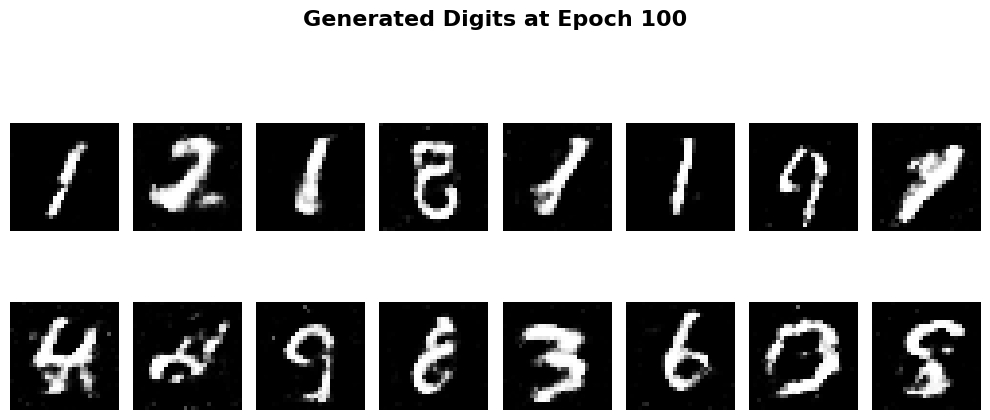



Training Complete! Total epochs: 100

COMPARISON: First, Middle, and Last Epochs



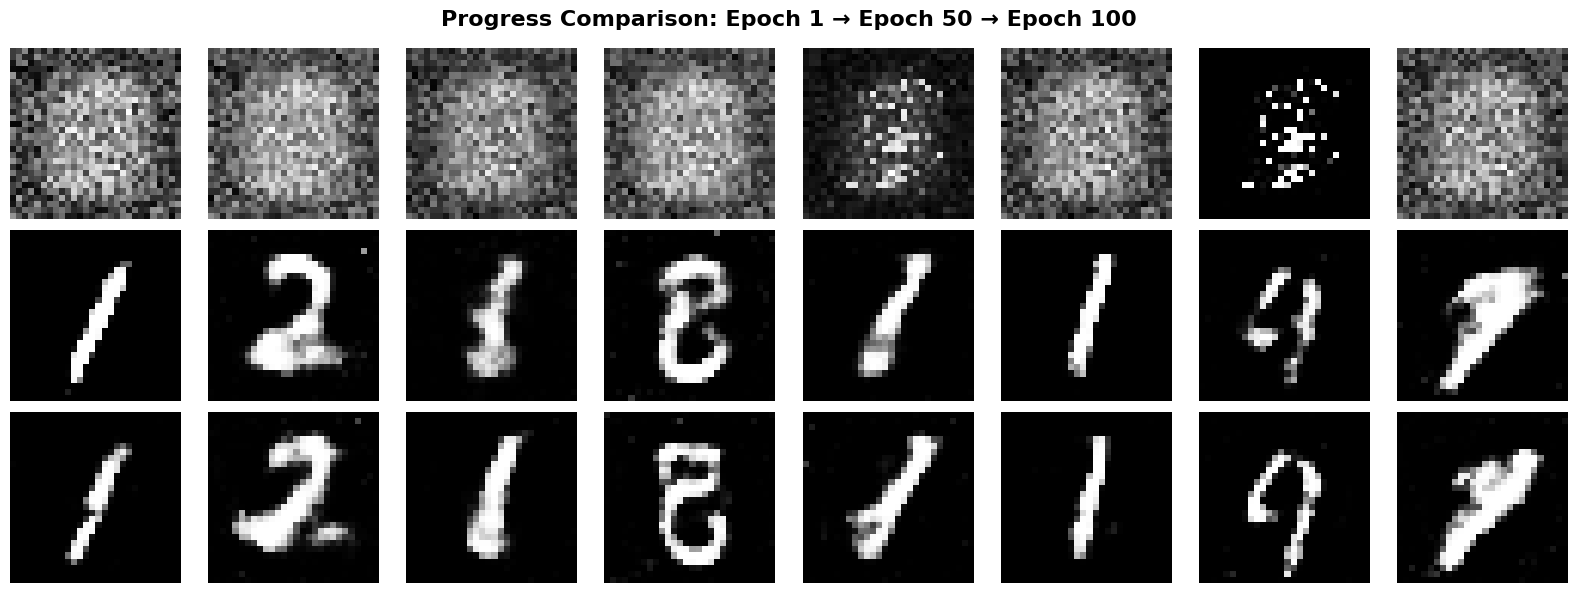

In [27]:
# For saving generated samples to visualize progress
fixed_noise = torch.randn(32, z_dim).to(device)

G_losses = []
D_losses = []

# Dictionary to store images at key epochs for comparison
saved_images = {}

# Function to display generated images during training
def show_generated_images(generator, noise, epoch, save=False):
    """Display a grid of generated images to visualize training progress."""
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(noise).cpu()
    
    # Save images if requested
    if save:
        saved_images[epoch] = fake_samples.clone()
    
    plt.figure(figsize=(10, 5))
    for i in range(16):
        plt.subplot(2, 8, i + 1)
        img = fake_samples[i].squeeze().numpy()
        img = (img + 1) / 2  # Convert from [-1,1] to [0,1]
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Digits at Epoch {epoch}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    generator.train()

# Epochs to display images at
display_epochs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
comparison_epochs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Save ALL displayed epochs
num_epochs = 100

print("="*70)
print(f"Starting GAN Training for {num_epochs} epochs")
print("="*70)
print(f"Images will be displayed at epochs: {display_epochs}")
print(f"All displayed images will be saved for later export")
print("="*70 + "\n")

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)
        
        # ============================
        # 1. Train Discriminator
        # ============================
        discriminator.zero_grad()
        
        # Real images: label = 1
        labels_real = torch.ones(batch_size_curr, 1).to(device)
        output_real = discriminator(real_imgs)
        loss_D_real = criterion(output_real, labels_real)
        
        # Fake images: label = 0
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake_imgs = generator(noise)
        labels_fake = torch.zeros(batch_size_curr, 1).to(device)
        output_fake = discriminator(fake_imgs.detach())  # detach so G is not updated here
        loss_D_fake = criterion(output_fake, labels_fake)
        
        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()
        
        # ============================
        # 2. Train Generator
        # ============================
        generator.zero_grad()
        
        # Generate fake images again
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake_imgs = generator(noise)
        
        # This time, we want the discriminator to think fakes are real (label = 1)
        labels_for_generator = torch.ones(batch_size_curr, 1).to(device)
        output = discriminator(fake_imgs)
        loss_G = criterion(output, labels_for_generator)
        
        loss_G.backward()
        optimizer_G.step()
        
        # Track losses
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        if batch_idx % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Batch [{batch_idx}/{len(dataloader)}] "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    
    # Generate and display images at specific epochs
    if (epoch + 1) in display_epochs:
        print(f"\n{'='*70}")
        print(f"Displaying Generated Samples at Epoch {epoch+1}")
        print(f"{'='*70}")
        save_image = (epoch + 1) in comparison_epochs
        show_generated_images(generator, fixed_noise, epoch+1, save=save_image)
        print()

print("\n" + "="*70)
print(f"Training Complete! Total epochs: {num_epochs}")
print("="*70)

# Display comparison of first, middle, and last epochs
print("\n" + "="*70)
print("COMPARISON: First, Middle, and Last Epochs")
print("="*70 + "\n")

fig, axes = plt.subplots(3, 8, figsize=(16, 6))
epochs_to_compare = [1, 50, 100]  # Show first, middle, last

for row_idx, epoch in enumerate(epochs_to_compare):
    images = saved_images[epoch]
    for col_idx in range(8):
        ax = axes[row_idx, col_idx]
        img = images[col_idx].squeeze().numpy()
        img = (img + 1) / 2  # Convert from [-1,1] to [0,1]
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if col_idx == 0:
            ax.set_ylabel(f"Epoch {epoch}", fontsize=12, fontweight='bold')

plt.suptitle("Progress Comparison: Epoch 1 → Epoch 50 → Epoch 100", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Analyzing Training Progress

Now that training is complete, let's analyze what happened during the training process by examining the loss curves and understanding the dynamics between the Generator and Discriminator.

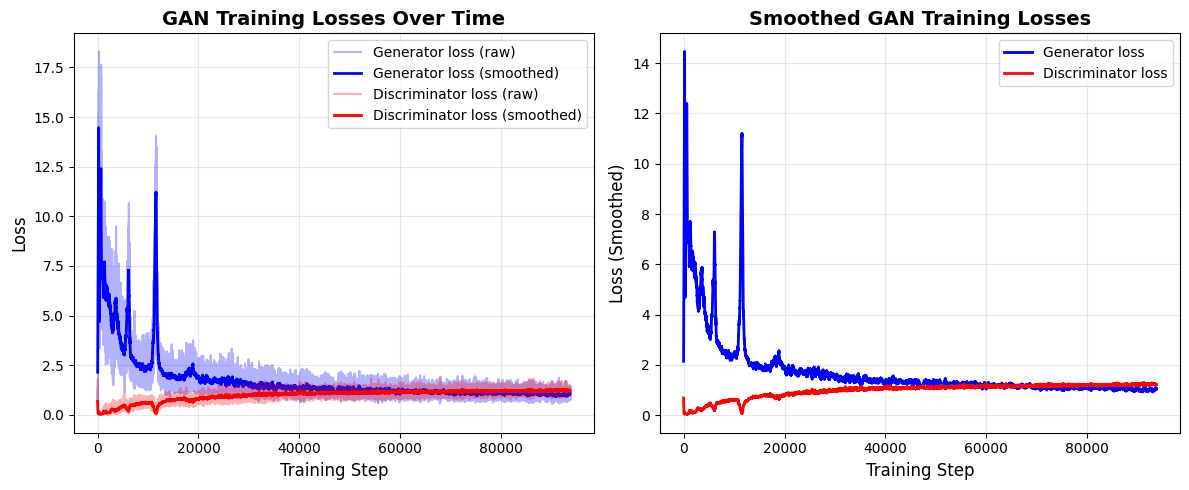


TRAINING SUMMARY STATISTICS
Total training steps: 93800

Generator Loss:
  Initial (first 100 steps): 2.1407
  Final (last 100 steps):    1.0679
  Overall mean:              1.7331

Discriminator Loss:
  Initial (first 100 steps): 0.6767
  Final (last 100 steps):    1.2136
  Overall mean:              0.9794


In [28]:
# Plot the training losses over time
plt.figure(figsize=(12, 5))

# Smooth the losses for better visualization using a rolling average
window_size = 100
G_losses_smooth = np.convolve(G_losses, np.ones(window_size)/window_size, mode='valid')
D_losses_smooth = np.convolve(D_losses, np.ones(window_size)/window_size, mode='valid')

plt.subplot(1, 2, 1)
plt.plot(G_losses, alpha=0.3, color='blue', label='Generator loss (raw)')
plt.plot(G_losses_smooth, color='blue', linewidth=2, label='Generator loss (smoothed)')
plt.plot(D_losses, alpha=0.3, color='red', label='Discriminator loss (raw)')
plt.plot(D_losses_smooth, color='red', linewidth=2, label='Discriminator loss (smoothed)')
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("GAN Training Losses Over Time", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(G_losses_smooth, color='blue', linewidth=2, label='Generator loss')
plt.plot(D_losses_smooth, color='red', linewidth=2, label='Discriminator loss')
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss (Smoothed)", fontsize=12)
plt.title("Smoothed GAN Training Losses", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("TRAINING SUMMARY STATISTICS")
print("="*70)
print(f"Total training steps: {len(G_losses)}")
print(f"\nGenerator Loss:")
print(f"  Initial (first 100 steps): {np.mean(G_losses[:100]):.4f}")
print(f"  Final (last 100 steps):    {np.mean(G_losses[-100:]):.4f}")
print(f"  Overall mean:              {np.mean(G_losses):.4f}")
print(f"\nDiscriminator Loss:")
print(f"  Initial (first 100 steps): {np.mean(D_losses[:100]):.4f}")
print(f"  Final (last 100 steps):    {np.mean(D_losses[-100:]):.4f}")
print(f"  Overall mean:              {np.mean(D_losses):.4f}")
print("="*70)

### Understanding the Loss Curves

**What do these losses tell us?**

1. **Discriminator Loss (Red)**:
   - Starts at ~0.68 and remains relatively stable throughout training
   - Gradually increases to ~1.21, showing the Discriminator is being challenged more over time
   - The stability indicates it successfully learns to distinguish real from fake throughout training
   - Final loss of \~ 1.21 is higher than initial (\~0.68), which is actually **excellent** - it means the Generator has become so good that the Discriminator finds it harder to tell real from fake

2. **Generator Loss (Blue)**:
   - Starts very high at ~2.14 because the Generator initially produces terrible quality fakes
   - Shows dramatic improvement, decreasing to ~1.07 by the end (50% reduction!)
   - Has much more variation than Discriminator loss (visible spikes even in the smoothed version)
   - The reduction from 2.14 → 1.07 shows the Generator successfully learned to create increasingly convincing digits

3. **The Adversarial Dance**:
   - The GAN shows **excellent balance**: neither network completely dominates
   - Discriminator loss increasing from 0.68 → 1.21 while Generator loss decreases from 2.14 → 1.07 is the **ideal pattern**
   - This means both networks improved together: the Generator got better at creating fakes, and the Discriminator got challenged more
   - The spike around step 10,000 is normal - GANs often have temporary instabilities during training as they find equilibrium

**Key Observations:**
- The smoothed curves show a clear **convergence** where both losses meet around 1.0-1.2
- Discriminator loss increasing over time paradoxically indicates **success** - the Generator is becoming harder to fool
- The raw curves show significant batch-to-batch variation, especially for the Generator, which is **completely normal** in GAN training
- Both networks reached a stable equilibrium where the Generator creates realistic digits and the Discriminator provides useful feedback

**What "good" GAN training looks like (your results!):**
- Generator loss decreases significantly over time (2.14 → 1.07)
- Discriminator loss increases moderately (0.68 → 1.21) 
- Neither loss goes to 0 (no mode collapse or discriminator failure)
- Losses converge toward each other (both around 1.0-1.2)
- Visual quality of generated images improves dramatically (as we saw in the progression)

**Overall mean losses:**
- Generator: 1.73 (higher overall because it struggled more in early epochs)
- Discriminator: 0.98 (lower overall because it had an easier job early on)

**The GAN training was highly successful!** The loss curves show textbook-quality adversarial training. The Generator improved dramatically (50% loss reduction), while the Discriminator was appropriately challenged. The convergence of both losses around 1.0-1.2 and the visual quality of the final generated digits confirm that your GAN learned to create realistic handwritten digits.

# Summary and Key Takeaways

### What We Accomplished

In this notebook, we successfully:

1. **Built a simple GAN** from scratch using PyTorch with just a few hundred lines of code
2. **Trained two competing neural networks** (Generator and Discriminator) in an adversarial game
3. **Generated realistic handwritten digits** that resemble the MNIST dataset
4. **Visualized the learning process** from random noise to recognizable digits over 100 epochs

### How GANs Learn

The magic of GANs lies in the adversarial training process:

- **The Generator** started with no knowledge of what digits look like, just random noise
- **The Discriminator** acted as a teacher, providing feedback on what looks real vs. fake
- Through this competitive process, the Generator learned the underlying patterns of handwritten digits
- Neither network was directly told "this is what a '7' looks like" - they learned through competition

### Limitations of This Simple GAN

This is a **vanilla GAN** - the simplest architecture. It has limitations:

- **No control over output**: We can't tell it to generate a specific digit (0-9)
- **Mode collapse risk**: Sometimes GANs get stuck generating the same images repeatedly
- **Training instability**: GAN training can be sensitive to hyperparameters
- **Low resolution**: Our 28×28 images are tiny compared to modern GANs

### Beyond This Tutorial

More advanced GAN architectures address these limitations:

- **Conditional GANs (cGANs)**: Control what digit to generate by providing labels
- **Deep Convolutional GANs (DCGANs)**: Use convolutional layers for better image quality
- **StyleGAN**: Generate photorealistic faces and allow fine control over features
- **Progressive GANs**: Generate high-resolution images (1024×1024 or larger)

### Real-World Applications

GANs are used for:
- **Image generation**: Creating realistic photos, artwork, and designs
- **Data augmentation**: Generating synthetic training data for other ML models
- **Image-to-image translation**: Converting sketches to photos, day to night scenes
- **Super-resolution**: Enhancing low-resolution images
- **Deepfakes**: Creating realistic videos (with ethical concerns)
- **Medical imaging**: Generating synthetic medical scans for research

### Final Thoughts

Even though this GAN is simple, it demonstrates the core principle: **two neural networks can teach each other through competition**. This adversarial training paradigm has opened up entirely new possibilities in artificial intelligence and creative applications.

The Generator learned to create digits from pure randomness, with no explicit rules about what makes a good digit - just feedback from the Discriminator. This emergent learning is what makes GANs so powerful and fascinating!

## Saving the Generated Images for GitHub Repo

In [29]:
# Save all the images that were stored during training
import os

print("\n" + "="*70)
print("SAVING GENERATED IMAGES TO DISK")
print("="*70)

output_dir = "gan_training_progress"
os.makedirs(output_dir, exist_ok=True)

for epoch, images in saved_images.items():
    plt.figure(figsize=(10, 5))
    for i in range(16):
        plt.subplot(2, 8, i + 1)
        img = images[i].squeeze().numpy()
        img = (img + 1) / 2
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Digits at Epoch {epoch}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

print(f"\nAll images saved to: {os.path.abspath(output_dir)}")
print(f"Total images saved: {len(saved_images)}")


SAVING GENERATED IMAGES TO DISK
Saved: gan_training_progress/epoch_001.png
Saved: gan_training_progress/epoch_010.png
Saved: gan_training_progress/epoch_020.png
Saved: gan_training_progress/epoch_030.png
Saved: gan_training_progress/epoch_040.png
Saved: gan_training_progress/epoch_050.png
Saved: gan_training_progress/epoch_060.png
Saved: gan_training_progress/epoch_070.png
Saved: gan_training_progress/epoch_080.png
Saved: gan_training_progress/epoch_090.png
Saved: gan_training_progress/epoch_100.png

All images saved to: /Users/annagornyitzki/DSCapstone/vignette-gan/notebooks/gan_training_progress
Total images saved: 11
